# Autocorrelación local



Anselin (1995) propuso indicadores locales de relaciones espaciales (*local indicators of spatial association* - LISA). LISA incluye estadísticos locales: $I_i$ de Moran y  $C_i$ de Geary. 

El estadístico de Moran local permite la identificación de efectos de **aglomeración espacial** (similar al estadístico $G$ Getis-Ord), mientras que el Geary local muestra **similitudes y diferencias espaciales**. 

Las estadísticas locales de Moran brindan **información sobre grupos de valor bajo o alto**, mientras que los estadísticos locales de Geary muestran **diferencias promedio entre el objeto y los vecinos**, lo que ayuda a encontrar **valores atípicos y patrones de similitud/diferencia**. 

Estos estadísticos están relacionadas con sus contrapartes globales y se pueden utilizar para estimar el **impacto de las estadísticas individuales en sus contrapartes globales**.

Gracias a LISA, es posible identificar los denominados puntos calientes, es decir, centros con valores altos rodeados de valores bajos, **así como clusters locales en ausencia de autocorrelación global**. Las áreas de alto valor pueden interpretarse no solo como puntos calientes, sino también como valores atípicos. Entonces, los estadísticos locales son un **indicador de inestabilidad local y desviaciones locales del patrón de autocorrelación global**.

LISA nos presentan dos componentes:

-   un estadístico para cada unidad espacial que puede ser sujeto a pruebas de significancia.

-   cuantifica la relación entre el estadístico global y el local: la suma de los estadísticos locales es proporcional al estadístico global.







### Estadístico local: $I$ de Moran

$$
I_i = \frac{(x_i-\bar{x})\sum_{j=1}^{n}w_{ij}(x_j-\bar{x})}{\sum_{i=1}^{n}(x_i-\bar{x})^2/n}
$$


Otra forma de expresar la I de Moran Local es:

$$
I_i = \frac{z_i}{m_2}\sum_{j=1}^{n}w_{ij}z_j; m_2 = \frac{\sum_{i=1}^{n}z_{i}^{2}}{n}
$$

donde $m_2$ es el segundo momento (varianza) de la distribución, $z_i = x_i-\bar{x}$, $w_{ij}$ es el peso espacial para el par de observaciones $i$ y $j$, y $n$ es el número de observaciones.

**Inferencia**

- Basado en comparar la estadística observada con una distribución empírica de referencia (bajo la hipótesis nula).

- $m$ = número de valores en la distribución de referencia que son **iguales o mayores (más extremos)** que el valor observado.

- $r$ = número de réplicas o permutaciones realizadas.

- La fórmula del pseudo valor-p es:

$$
p = \frac{(m + 1)}{(r + 1)}
$$


**Valor-p Pseudo - Interpretación**

- Los valores-p no son directamente comparables.
  - **NO** son lo mismo que un valor-p analítico.
- El valor depende del número de permutaciones.

**Comparación:**

Nota que en los siguientes casos (ambos) no se tiene observaciones de la distribución de referencia que sea mayor o igual que el valor observado. 

Si el valor de las permutaciones aumenta de 99 a 999 se tiene una mejor aproximación de la distribución de referencia, pero igual se tiene 0 casos estos valores sean mayores al observado:

- $(0 + 1) / (99 + 1) = 0.01$
- $(0 + 1) / (999 + 1) = 0.001$

Pero en ambos casos, el valor observado es el más extremo, no hay valores mayores en la de referencia. En este caso estaríamos tentados a decir que el segungo pvalor es más siginificativo, pero no es cierto. Ambos tienen **igual evidencia que el estadísitico I de Moran local es extermo** en relación a la distribución de referencia. 

Esta es una gran diferencia entre un pseudo pvalor y un pvalor analítico basado en un marco de probabilidad formal. El pseudo pvalor es computacional. Más sobre este tema en: https://hastie.su.domains/CASI/


### Una aplicación: la pobreza por necesidades básica insatisfechas
Para leer los datos de un archivo `shp` de github usaremos la función `read_git_shp`:

In [1]:
import requests
from io import BytesIO
import zipfile
import geopandas as gpd
import tempfile
import os

def read_git_shp(nombre, url):
    response = requests.get(url)
    if response.status_code != 200:
        raise Exception(f"Error al descargar shapefile: {response.status_code}")
    
    zip_bytes = BytesIO(response.content)

    with zipfile.ZipFile(zip_bytes, "r") as z:
        shp_files = [f for f in z.namelist() if f.endswith(nombre + ".shp")]
        if not shp_files:
            raise FileNotFoundError(f"No se encontró {nombre}.shp en el zip")
        
        shp_name = shp_files[0]
        with tempfile.TemporaryDirectory() as tmpdirname:
            z.extractall(tmpdirname)
            gdf = gpd.read_file(os.path.join(tmpdirname, shp_name))
    return gdf

# Uso correcto
#url = "https://github.com/vmoprojs/DataLectures/raw/master/SpatialData/SHP.zip"
#df = read_git_shp("nxprovincias", url)


Ahora importamos el valor agregado anual por cantones del Ecuador tomados del Banco Central del Ecuador y el indicador de Necesidades Básicas Insatisfechas por personas. 

In [12]:
import pandas as pd
import geopandas as gpd
import requests
import zipfile
import io
import os

# 1. Leo los datos del VAB no petrolero por cantones 2007-2019
url_vab = "https://raw.githubusercontent.com/vmoprojs/DataLectures/master/SpatialData/VABNoPetroleroCantones2007-2019.csv"
datos = pd.read_csv(url_vab, sep=",")

# 2. Relleno con 0 los códigos de cantón que solo tienen 3 caracteres (para normalizar a 4 dígitos)
datos['COD_CANT'] = datos['COD_CANT'].astype(str)
datos.loc[datos['COD_CANT'].str.len() == 3, 'COD_CANT'] = '0' + datos.loc[datos['COD_CANT'].str.len() == 3, 'COD_CANT']

# 3. Filtrar los datos para el año 2019
datos = datos[datos['YEAR'] == 2019]

# 4. Leo los datos de población proyectada 2010–2020
url_poblacion = "https://raw.githubusercontent.com/vmoprojs/DataLectures/master/SpatialData/proyeccion_cantonal_total_2010-2020.csv"
poblacion = pd.read_csv(url_poblacion, sep=";")

# 5. Normalizo los códigos de cantón para que tengan 4 caracteres (agregando un 0 a los que tienen 3)
poblacion['CODIGO'] = poblacion['CODIGO'].astype(str)
poblacion.loc[poblacion['CODIGO'].str.len() == 3, 'CODIGO'] = '0' + poblacion.loc[poblacion['CODIGO'].str.len() == 3, 'CODIGO']

# 6. Leo los datos de Necesidades Básicas Insatisfechas (NBI)
url_nbi = "https://raw.githubusercontent.com/vmoprojs/DataLectures/master/SpatialData/NBI_PER_CANT.csv"
nbi = pd.read_csv(url_nbi, sep=";")

# 7. Normalizo los códigos de cantón
nbi['CODIGO'] = nbi['CODIGO'].astype(str)
nbi.loc[nbi['CODIGO'].str.len() == 3, 'CODIGO'] = '0' + nbi.loc[nbi['CODIGO'].str.len() == 3, 'CODIGO']


# 8. Uno los datos de población a los datos económicos usando el código de cantón
datos = datos.merge(poblacion[['CODIGO', 'A_2019']], left_on='COD_CANT', right_on='CODIGO', how='left')


# 9. Uno los datos de pobreza (NBI) a los datos existentes
datos = datos.merge(nbi[['CODIGO', 'POBRES_P']], left_on='COD_CANT', right_on='CODIGO', how='left')

# 10. Calculo el VAB per cápita: VAB dividido por la población proyectada en 2019
datos['VAB_PC'] = datos['VAB'] / datos['A_2019']  # miles de USD por persona

# 11. Descargo y leo el shapefile con los polígonos cantonales
url = "https://github.com/vmoprojs/DataLectures/raw/master/SpatialData/SHP.zip"
poligonos = read_git_shp("nxcantones", url)

Una vez extraida la información y el shapefile, quitamos a Galápagos y juntamos los datos a `poligonos`

In [13]:

# 1. Filtro para excluir la provincia "90"
#poligonos = poligonos[poligonos['DPA_PROVIN'] != "90"]

# 2. Filtro para excluir la provincia "20"
poligonos = poligonos[poligonos['DPA_PROVIN'] != "20"]


# 3. Hacer el merge entre los polígonos y los datos económicos por cantón
# Se usa la columna 'DPA_CANTON' del shapefile y 'COD_CANT' del DataFrame 'datos'
poligonos = poligonos.merge(datos, left_on='DPA_CANTON', right_on='COD_CANT', how='left')

# 4. Eliminar las filas que tienen valores faltantes en la variable 'POBRES_P'
# Esto equivale a quedarse solo con los cantones que tienen datos de pobreza
poligonos = poligonos[~poligonos['POBRES_P'].isna()]

#poligonos['POBRES_P'].isna()

In [14]:
poligonos.columns

Index(['DPA_CANTON', 'DPA_DESCAN', 'DPA_VALOR', 'DPA_ANIO', 'DPA_PROVIN',
       'DPA_DESPRO', 'SUPERFICIE', 'geometry', 'NOM_PROV', 'COD_PROV',
       'NOM_CANT', 'COD_CANT', 'PRODUCCION', 'CONSUMO_INTERMEDIO', 'VAB',
       'YEAR', 'TIPO', 'CODIGO_x', 'A_2019', 'CODIGO_y', 'POBRES_P', 'VAB_PC'],
      dtype='object')

<Axes: >

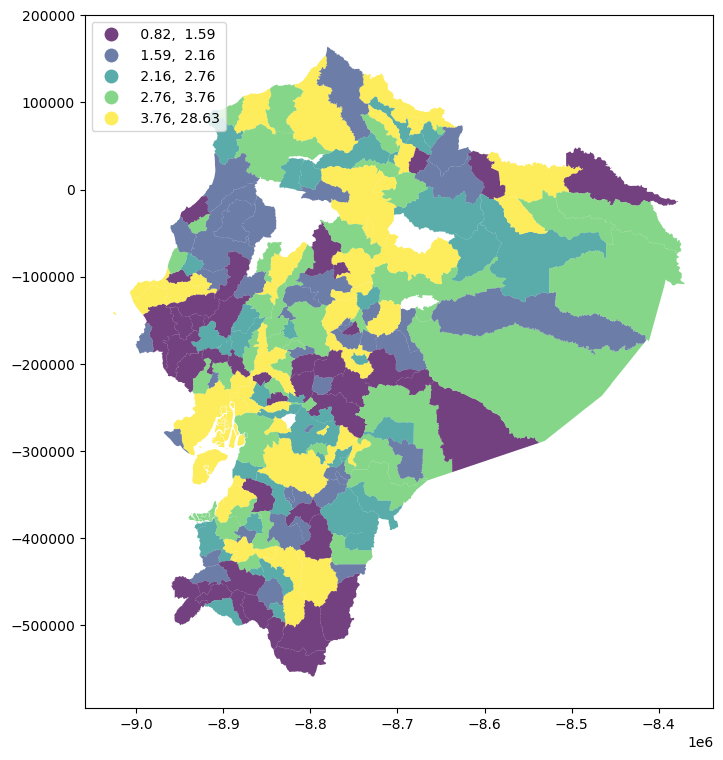

In [15]:
import matplotlib.pyplot as plt


# Reproyección a Web Mercator para usar contextily
poligonos = poligonos.to_crs(epsg=3857)

f, ax = plt.subplots(1, figsize=(9, 9))
poligonos.plot(
    column="VAB_PC",
    cmap="viridis",
    scheme="quantiles",
    k=5,
    edgecolor="white",
    linewidth=0.0,
    alpha=0.75,
    legend=True,
    legend_kwds={"loc": 2},
    ax=ax,
)

Antes de analizar la autocorrelación espacial, es fundamental definir la matriz de pesos espaciales. En este caso, se adopta el **criterio reina** como referencia, aunque, como se mencionó anteriormente, existen múltiples formas válidas de construir esta matriz. Para garantizar la comparabilidad entre unidades, los pesos se estandarizan por filas.

In [16]:
import geopandas as gpd
from libpysal.weights import Queen
from libpysal.weights import W

# 1. Construir la lista de vecinos usando contigüidad tipo Reina
# El parámetro silence_warnings=True es útil si hay geometrías sin vecinos
w_queen = Queen.from_dataframe(poligonos, silence_warnings=True,use_index=True)

# 2. Convertir la lista de vecinos a una matriz de pesos estilo "W" (filas normalizadas)
# libpysal ignora por defecto las unidades sin vecinos
w_queen.transform = 'R'  # "R" es row-standardized

# Si deseas acceder directamente a la matriz de pesos como un diccionario:
weights_matrix = w_queen.full()  # O usar .neighbors y .weights para listas directas

# También puedes verificar qué observaciones no tienen vecinos:
islands = w_queen.islands  # Lista de índices (cantones) sin vecinos
islands

[]

**Calculamos el estadístico local Moran I**



In [17]:
import esda
y = poligonos["POBRES_P"]
lisa = esda.moran.Moran_Local(y, w_queen)

Necesitamos pasar la variable de interés —`POBRES_P`— y los pesos espaciales que describen las relaciones de vecindad entre las distintas áreas que conforman el conjunto de datos (`w_queen`). Esto crea un objeto LISA (`lisa`) que contiene varios atributos relevantes. Los indicadores locales propiamente tales se encuentran en el atributo `Is`, y podemos hacernos una idea de su distribución utilizando el siguiente gráfico:

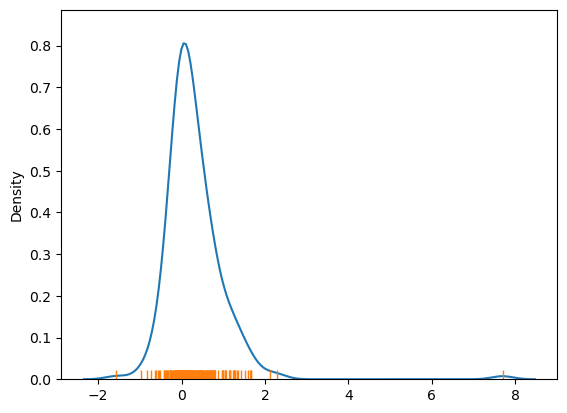

In [18]:
import seaborn as sns
# Dibujar la curva de densidad de kernel (KDE) para visualizar la distribución suavizada
# de los valores del estadístico local de autocorrelación espacial (por ejemplo, I de Moran local)
ax = sns.kdeplot(lisa.Is)

# Añadir una línea vertical pequeña (rug) para cada observación individual sobre el eje X.
# Esto permite ver exactamente dónde se ubican los valores individuales de lisa.Is
sns.rugplot(lisa.Is, ax=ax);

La figura muestra que la distribución de los valores del estadístico local de Moran ($I_i$) está ligeramente sesgada hacia la derecha, es decir, predominan los valores positivos. 

Esto se debe a que existen formas positivas de asociación espacial, lo que implica que muchas áreas geográficas tienen valores similares a los de sus vecinas. 

Es importante tener en cuenta que un valor alto de $I_i$ puede deberse a dos situaciones distintas:
- Zonas con valores altos agrupadas entre sí.
- Zonas con valores bajos agrupadas entre sí.

Sin embargo, el valor de $I_i$ por sí solo **no permite diferenciar** entre estos dos casos.

Esto resalta la necesidad de utilizar herramientas adicionales para interpretar correctamente los patrones espaciales locales.

--- 

Los valores que se encuentran en el extremo izquierdo de la distribución de densidad representan ubicaciones con **asociación espacial negativa**.

Esto puede reflejar dos patrones distintos:
- Un valor alto rodeado de valores bajos.
- Un valor bajo rodeado de valores altos.

Sin embargo, al igual que en el caso de los valores positivos, el estadístico local $I_i$ **no puede diferenciar entre estas dos situaciones**.

Esto limita su capacidad interpretativa y destaca la importancia de usar herramientas complementarias para una interpretación más precisa de los patrones espaciales.

---

Dado que los LISA generan un estadístico para cada observación individual, analizar sus resultados numéricos directamente no siempre es la mejor forma de aprovechar toda la información disponible, especialmente cuando se trabaja con muchos datos.

En este contexto, un **mapa coroplético** de los valores $I_i$ puede ayudar a visualizar la distribución espacial. Aunque dicho mapa permite identificar si la asociación local es positiva (HH o LL) o negativa (HL o LH), no es suficiente para saber si diferentes áreas con valores similares están experimentando los mismos patrones espaciales.

Por ejemplo, si dos regiones aparecen con el mismo color, no es posible saber si reflejan un patrón similar o si una es HH y la otra LL.

Además, los valores cercanos a cero no suelen ser estadísticamente significativos. Por tanto, es importante distinguir:
- ¿Qué valores locales son estadísticamente significativos?
- ¿Cuáles no lo son?
- ¿Cuáles pueden considerarse verdaderos **clústeres estadísticos** y cuáles son simplemente **ruido**?

Este tipo de preguntas no puede responderse solo con el valor numérico de $I_i$, lo que resalta la necesidad de incorporar la significancia estadística en la interpretación.

--- 

Para responder correctamente a las preguntas que surgen al interpretar los estadísticos LISA, es necesario incorporar información adicional que se calcula junto con esos estadísticos.

Este análisis se realiza en **cuatro pasos**:

1. Un **mapa coroplético** simple que muestre el valor del estadístico local $I_i$ en cada área.
2. Información sobre el **cuadrante** en el que se ubica cada área, lo cual indica el tipo de asociación (por ejemplo, Alto-Alto, Bajo-Bajo, Alto-Bajo, etc.).
3. Un indicador sobre si el estadístico es **estadísticamente significativo** o no.
4. Una **combinación de los elementos anteriores** en un único **mapa de clústeres**, que permite identificar patrones espaciales relevantes.

Una herramienta útil para crear estas visualizaciones es la librería `splot`, que forma parte del ecosistema de **PySAL** y proporciona una capa ligera para representar gráficamente estadísticas espaciales.


**Paso 1:**

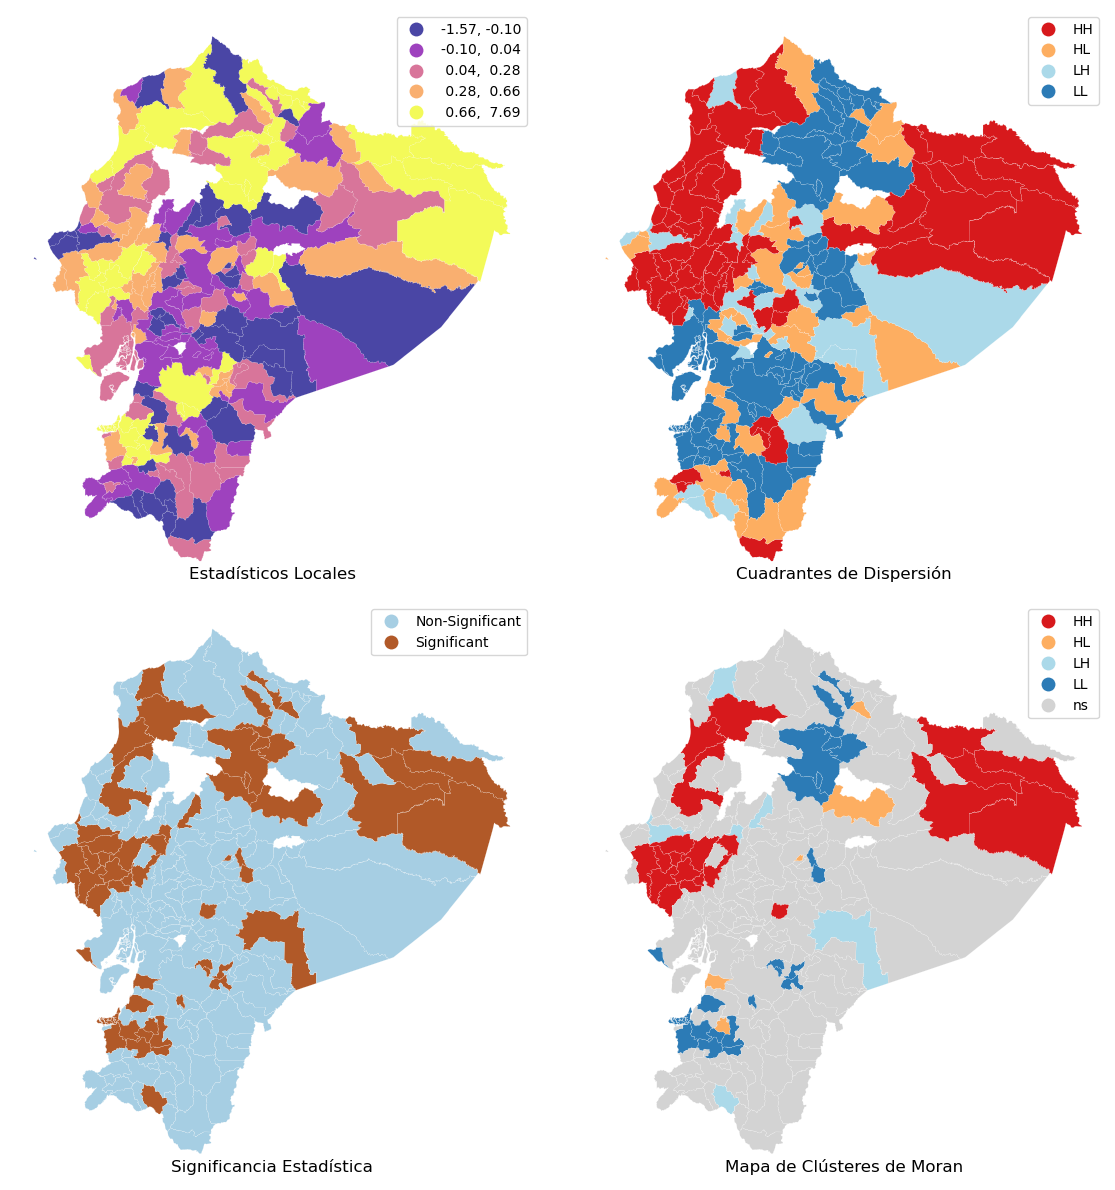

In [21]:
from splot import esda as esdaplot  # Importa el módulo de visualización 'esda' desde el paquete splot, que se usa para graficar resultados LISA (análisis local de autocorrelación espacial), y lo renombra como 'esdaplot'

# Configura la figura principal con una grilla de 2 filas y 2 columnas de subgráficos
f, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 12))

# Convierte la matriz 2x2 de ejes (axs) en una lista de 4 elementos para facilitar su acceso por índice
axs = axs.flatten()

# ---------- Subgráfico 1 ----------
# Mapa de coropletas de los estadísticos locales de autocorrelación (I de Moran local)
ax = axs[0]  # Selecciona el primer eje (arriba a la izquierda)

# Crea una copia del GeoDataFrame 'poligonos' asignando una nueva columna 'Is' con los valores de autocorrelación local lisa.Is
# Luego genera un mapa de coropletas usando esa columna
poligonos.assign(
    Is=lisa.Is  # Asignación temporal de los valores de I local como nueva columna
).plot(
    column="Is",             # La variable a representar en el mapa
    cmap="plasma",           # Paleta de colores a usar (gradiente)
    scheme="quantiles",      # Clasificación por cuantiles
    k=5,                     # Número de clases/categorías (cuantiles)
    edgecolor="white",       # Color del borde de los polígonos
    linewidth=0.1,           # Grosor de las líneas de borde
    alpha=0.75,              # Transparencia del relleno
    legend=True,             # Mostrar la leyenda del mapa
    ax=ax,                   # Eje donde se dibuja el gráfico
)

# ---------- Subgráfico 2 ----------
# Mapa de cuadrantes del diagrama de dispersión de Moran
ax = axs[1]  # Segundo eje (arriba a la derecha)

# Dibuja un mapa con los cuadrantes (HH, LL, HL, LH) asignados a cada polígono
# Aquí se fuerza p=1 para que todas las observaciones se consideren significativas (esto es útil para visualización exploratoria)
esdaplot.lisa_cluster(lisa, poligonos, p=1, ax=ax)

# ---------- Subgráfico 3 ----------
# Mapa de significancia estadística (p < 0.05)
ax = axs[2]  # Tercer eje (abajo a la izquierda)

# Crea una serie de etiquetas binarias donde 1 indica significancia (p_sim < 0.05) y 0 no significancia
labels = pd.Series(
    1 * (lisa.p_sim < 0.05),  # Evaluación booleana convertida a 0/1
    index=poligonos.index     # Asegura que los índices coincidan con el GeoDataFrame original
).map({1: "Significant", 0: "Non-Significant"})  # Mapea 0 y 1 a etiquetas más legibles

# Asigna la nueva variable de etiquetas ('cl') al GeoDataFrame y dibuja un mapa categórico de áreas significativas y no significativas
poligonos.assign(
    cl=labels
).plot(
    column="cl",              # La columna con las etiquetas categóricas
    categorical=True,         # Se indica que es una variable categórica
    k=2,                      # Dos clases: significativa y no significativa
    cmap="Paired",            # Paleta de colores adecuada para categorías
    linewidth=0.1,            # Líneas delgadas entre polígonos
    edgecolor="white",        # Borde blanco
    legend=True,              # Mostrar leyenda
    ax=ax,                    # Dibujar en el tercer eje
)

# ---------- Subgráfico 4 ----------
# Mapa de clústeres LISA reales (considerando significancia)
ax = axs[3]  # Cuarto eje (abajo a la derecha)

# Dibuja los clústeres espaciales LISA considerando solamente las observaciones significativas (p < 0.05)
esdaplot.lisa_cluster(lisa, poligonos, p=0.05, ax=ax)

# ---------- Estilización de la figura completa ----------
# Asigna títulos a cada uno de los subgráficos y oculta los ejes para mejorar presentación
for i, ax in enumerate(axs.flatten()):
    ax.set_axis_off()  # Oculta los ejes (coordenadas, ticks)
    ax.set_title(
        [
            "Estadísticos Locales",          # Título del subplot 1
            "Cuadrantes de Dispersión",      # Título del subplot 2
            "Significancia Estadística",     # Título del subplot 3
            "Mapa de Clústeres de Moran",    # Título del subplot 4
        ][i],
        y=0,  # Posición vertical del título (alineado abajo)
    )

# Ajusta automáticamente el espaciado entre subgráficos para que no se sobrepongan
f.tight_layout()

# Muestra en pantalla la figura completa con los cuatro subgráficos
plt.show()



Las zonas marcadas en púrpura y amarillo en el mapa (esquina superior izquierda) presentan los valores de mayor magnitud, tanto positivos como negativos, del estadístico local $I_i$.

Sin embargo, esto solo indica una **autocorrelación espacial positiva**, la cual puede darse tanto en valores altos como en valores bajos.

Por lo tanto, este tipo de mapa **no permite diferenciar** si se trata de áreas con **baja pobreza** o con **alta pobreza**. Solo muestra que las áreas tienen valores similares entre ellas, pero no especifica si esos valores son altos o bajos.


--- 

Para diferenciar entre áreas con valores altos o bajos, el mapa en la esquina superior derecha muestra en qué **cuadrante del gráfico de dispersión de Moran** se encuentra cada estadístico LISA.

Esto permite identificar si la asociación local positiva (o negativa) corresponde, por ejemplo, a un clúster de valores altos (HH) o bajos (LL), o bien a combinaciones opuestas (HL o LH).

Esta clasificación se almacena en el **atributo `q`** del objeto `lisa`, que asigna cada observación a un cuadrante específico del gráfico de Moran.



In [22]:
lisa.q[:10]

array([3, 3, 3, 1, 3, 4, 3, 3, 4, 1])


El atributo `q` del objeto `lisa` indica a qué cuadrante pertenece cada observación del gráfico de dispersión de Moran. La correspondencia es la siguiente:

- `1` → Cuadrante **HH**: valores altos rodeados de valores altos.
- `2` → Cuadrante **LH**: valores bajos rodeados de valores altos.
- `3` → Cuadrante **LL**: valores bajos rodeados de valores bajos.
- `4` → Cuadrante **HL**: valores altos rodeados de valores bajos.

Esto permite identificar no solo la fuerza de la autocorrelación, sino también la naturaleza del patrón espacial observado.


In [23]:
counts = pd.Series(lisa.q).value_counts()
counts

3    78
1    64
4    41
2    24
Name: count, dtype: int64


Los valores correspondientes a los cuadrantes **HH (1)** y **LL (3)** son los más comunes. Sin embargo, es importante tener precaución al interpretar estos mapas, ya que **no se ha tenido en cuenta la significancia estadística** de los valores locales.

Lo que se ha hecho es simplemente mapear los valores brutos de LISA junto con el cuadrante correspondiente, sin evaluar si esos valores son estadísticamente significativos.

Para abordar esto, el mapa inferior izquierdo distingue entre:
- Polígonos con un **pseudo-valor p mayor al 5%** (clasificados como *No Significativos*).
- Polígonos con un **pseudo-valor p menor al 5%** (clasificados como *Significativos*).

Este análisis revela que muchas autoridades locales presentan valores LISA **tan pequeños que podrían explicarse por azar**, es decir, **no representan patrones espaciales significativos**.

---


Para centrarnos en las áreas más relevantes, es fundamental incorporar información sobre la **significancia estadística** junto con el cuadrante y el estadístico local. Esto se logra mediante un **mapa de clústeres**, que identifica las observaciones estadísticamente significativas (es decir, aquellas que probablemente no se deben al azar) y las representa con colores específicos según su cuadrante.

Toda esta información ya está contenida en el objeto `lisa` generado previamente. Si lo combinamos con la tabla geoespacial correspondiente, la librería `splot` puede generar automáticamente el mapa de clústeres.

Este mapa revela patrones importantes que podrían pasar desapercibidos en los mapas anteriores. Por ejemplo, muestra que **menos de la mitad de los polígonos** tienen una asociación espacial local lo suficientemente fuerte como para descartar que se deba al azar, lo cual es un hallazgo clave en el análisis estadístico espacial.



In [24]:
(lisa.p_sim < 0.05).sum() * 100 / len(lisa.p_sim)


27.053140096618357

El análisis muestra que un poco más del **27% de las autoridades locales** forman parte de un clúster espacial significativo.


Antes de pasar a otro tema, es útil comprender cómo **exportar la información de significancia y cuadrantes** contenida en el objeto `lisa`.

- Aunque `splot` se encarga de crear automáticamente los mapas de clústeres, **internamente se procesan muchos datos**.
- Si queremos **recrear un mapa manualmente** o **usar esa información en otro contexto**, necesitamos extraerla del objeto `lisa` y vincularla a la tabla de datos geoespaciales original (`poligonos`).

Esto permite integrar los resultados en una canalización de datos más amplia o realizar análisis personalizados fuera del flujo automatizado.


In [26]:
# Asignar los valores de pseudo p (p-sim) del objeto `lisa` al DataFrame `db`
poligonos["p-sim"] = lisa.p_sim

# Crear una variable binaria que indique significancia estadística:
# asigna 1 si el valor p es menor a 0.05 (es decir, es significativo al 5%), y 0 en caso contrario
sig = 1 * (lisa.p_sim < 0.05)

# Asignar esta variable de significancia al DataFrame `db` como una nueva columna llamada "sig"
poligonos["sig"] = sig

# Mostrar las primeras filas de las columnas "sig" y "p-sim" para revisar que se haya realizado correctamente
poligonos[["sig", "p-sim"]].head()


sig  p-sim
0    0  0.055
1    0  0.062
2    1  0.031
3    0  0.451
4    1  0.007

In [27]:
poligonos[["sig", "p-sim"]].tail()

sig  p-sim
208    1  0.013
209    1  0.020
210    1  0.015
211    0  0.104
212    0  0.452



Para identificar los valores del estadístico local de Moran (LISA) que **son estadísticamente significativos**, se utiliza la columna `sig`.


La librería `esda` calcula automáticamente un **pseudo-valor p** para cada observación de LISA, mediante la simulación de **cientos de miles de mapas aleatorios**. Este procedimiento permite estimar qué tan probable es que un valor observado haya ocurrido solo por azar.



Se establece un **umbral del 5%** (0.05), igual que con el estadístico de Moran global:
- Si el valor p es **menor o igual a 0.05**, se considera **significativo** (`sig = True`).
- En caso contrario, **no es significativo** (`sig = False`).


Después, se utilizan los cuadrantes almacenados en el atributo `q` (que indica si una observación pertenece a HH, LL, HL o LH), pero **filtrando solo aquellas observaciones que son significativas según `sig`**.

De esta manera, **solo se visualizan y analizan los clústeres que tienen respaldo estadístico**, y el resto se clasifica como no significativo.


In [28]:
# Selecciona como parte de un cuadrante solo los polígonos que son estadísticamente significativos;
# en caso contrario (no significativos), asigna 0 → “No Significativo”
spots = lisa.q * sig

# Diccionario que asigna a cada valor numérico del cuadrante una etiqueta descriptiva
spots_labels = {
    0: "Non-Significant",  # 0: No significativo
    1: "HH",                # 1: Alto - Alto (alta autocorrelación positiva)
    2: "LH",                # 2: Bajo - Alto (outlier bajo rodeado de altos)
    3: "LL",                # 3: Bajo - Bajo (baja autocorrelación positiva)
    4: "HL",                # 4: Alto - Bajo (outlier alto rodeado de bajos)
}

# Crea una nueva columna "labels" en el DataFrame `db` que contiene las etiquetas descriptivas por polígono
poligonos["labels"] = pd.Series(
    spots,            # Serie con los valores de cuadrantes (considerando solo los significativos)
    index=poligonos.index    # Asegura que los índices coincidan con el DataFrame original
).map(spots_labels)   # Traduce cada valor numérico a su etiqueta usando el diccionario

# Muestra las primeras filas de la nueva columna para inspeccionar visualmente el resultado
poligonos["labels"].head()


0    Non-Significant
1    Non-Significant
2                 LL
3    Non-Significant
4                 LL
Name: labels, dtype: object



Los **etiquetados de clústeres** obtenidos a partir del gráfico de dispersión de Moran pueden resultar más intuitivos si se asocian a nombres descriptivos. Esta terminología mnemotécnica ayuda a recordar la naturaleza de cada patrón espacial:


- **HH (High-High)**: áreas con valores altos rodeadas de valores altos. Se conocen como **"hot spots"** (puntos calientes).
- **LL (Low-Low)**: áreas con valores bajos rodeadas de valores bajos. Se denominan **"cold spots"** (puntos fríos).

- **LH (Low-High)**: valores bajos rodeados de valores altos. Se llaman **"doughnuts"** (rosquillas).
- **HL (High-Low)**: valores altos rodeados de valores bajos. Se les puede llamar **"diamonds in the rough"** (diamantes en bruto).

> Aunque esta terminología no es técnica, puede facilitar la comprensión y recordación de los distintos tipos de asociaciones locales.

---

Una vez construidas estas columnas (como `sig` y `q`), el análisis de tendencias generales en las estadísticas LISA se vuelve más sencillo, y puede realizarse directamente a partir del objeto `lisa`.


In [29]:
poligonos["labels"].value_counts()

labels
Non-Significant    151
LL                  24
HH                  21
LH                   6
HL                   5
Name: count, dtype: int64



Este análisis demuestra que **la mayoría de los estadísticos locales no son estadísticamente significativos**.

Entre los que sí lo son, se observa una clara predominancia de:
- **Hotspots** (HH: valores altos rodeados de altos)
- **Coldspots** (LL: valores bajos rodeados de bajos)

en comparación con:
- **Doughnuts** (LH: valores bajos rodeados de altos)
- **Diamonds in the rough** (HL: valores altos rodeados de bajos)

Este patrón es coherente con el **sesgo en la distribución de los estadísticos locales** observado anteriormente.
